In [54]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Embedding, Dropout, Activation, Reshape, Concatenate, Flatten
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
embed_file = os.path.join('.', 'fasttext', 'wiki-news-300d-1M.vec')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [4]:
embed_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [5]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_test = test["comment_text"].fillna("_na_").values

In [6]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_train)+list(list_test))
tokenized_train = tokenizer.texts_to_sequences(list_train)
tokenized_test = tokenizer.texts_to_sequences(list_test)
X_t = pad_sequences(tokenized_train, maxlen=maxlen)
X_te = pad_sequences(tokenized_test, maxlen=maxlen)

In [13]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embed_file, encoding = 'utf-8'))

In [40]:
#print (len(embeddings_index))
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

999995


(-0.0033459952, 0.1112124)

In [41]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [48]:
filter_sizes = [1,2,3,5]
num_filters = 32

In [58]:
from keras import backend as K
K.clear_session()

In [59]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Reshape((maxlen, embed_size, 1))(x)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), activation = 'relu')(x)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), activation = 'relu')(x)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), activation = 'relu')(x)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), activation = 'relu')(x)

maxpool_0 = MaxPooling2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
maxpool_1 = MaxPooling2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
maxpool_2 = MaxPooling2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
maxpool_3 = MaxPooling2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)

z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
z = Flatten()(z)
x = Dropout(0.1)(z)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9, random_state=9)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [62]:
cp = ModelCheckpoint(filepath="my_model4.h5", save_best_only=True)
es = EarlyStopping(patience=1)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit(X_tra, y_tra, batch_size = 256, epochs=10, validation_data=(X_val, y_val), callbacks=[cp, es, rp, RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 883s 6ms/step - loss: 0.0765 - acc: 0.9768 - val_loss: 0.0497 - val_acc: 0.9824

 ROC-AUC - epoch: 1 - score: 0.973506 

Epoch 2/10
143613/143613 [==============================] - 945s 7ms/step - loss: 0.0465 - acc: 0.9829 - val_loss: 0.0471 - val_acc: 0.9831

 ROC-AUC - epoch: 2 - score: 0.981763 

Epoch 3/10
143613/143613 [==============================] - 952s 7ms/step - loss: 0.0394 - acc: 0.9849 - val_loss: 0.0470 - val_acc: 0.9831

 ROC-AUC - epoch: 3 - score: 0.982245 

Epoch 4/10
143613/143613 [==============================] - 934s 7ms/step - loss: 0.0319 - acc: 0.9878 - val_loss: 0.0471 - val_acc: 0.9833

 ROC-AUC - epoch: 4 - score: 0.982118 



{'val_loss': [0.049734325003313574, 0.04705372554610615, 0.046977679999079494, 0.04711584527447478], 'val_acc': [0.9824225892472617, 0.9831014514148706, 0.9830805616564643, 0.9833312263269445], 'loss': [0.07645400209459, 0.04650958538792421, 0.03937604466810995, 0.0319256458445386], 'acc': [0.9767964172034407, 0.9828508790512199, 0.9849003719782808, 0.9878132943352087], 'lr': [0.001, 0.001, 0.001, 0.000100000005]}


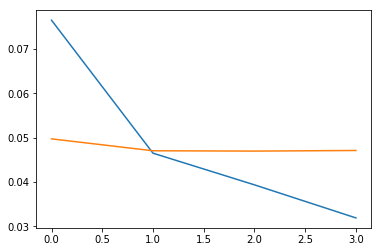

In [63]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [64]:
y_pred = model.predict(X_te, batch_size=1024)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission4.csv', index=False)